# Student Alcohol Consumption
## By James McCutcheon, Emily Tao, Sean Campbell, and Akhila Bhamidipati

## Overview
It is well understood that binge drinking has a negative effect on the adolescent brain. Effects include [damaged brain tissue](https://www.npr.org/templates/story/story.php?storyId=122765890), which impacts thinking and memory, as well as decreased function in the liver and [heart](http://www.heart.org/en/healthy-living/healthy-eating/eat-smart/nutrition-basics/alcohol-and-heart-health). According to [this article](https://www.niaaa.nih.gov/alcohol-health/overview-alcohol-consumption/alcohol-facts-and-statistics) from the National Institute on Alcohol Abuse and Alcoholism, the World Health Organization reported in 2012 that alcohol was a contributing factor in over two-hundred injuries and diseases, including multiple types of cancer and liver cirrhosis. With all of these risks, it is important to protect teenagers and young adults by addressing the underlying causes of drinking. However, the challenge lies in detecting those that are at risk for dangerous drinking behaviors so that personalized assistance can be given.  


### Our Data Set
Our [dataset](https://www.kaggle.com/uciml/student-alcohol-consumption/home) was found on Kaggle, and contains social, gender, and study data from secondary school students in Portugal. The data was collected in 2008 and was presented at the 5th Future Business Technology Conference by P. Cortez and A. Silva. The given dataset contains data from thirty difference features about students at two schools in Portugal, and is presented in two different datasets; one dataset contained students from a math course, and the other dataset contained students from a Portuguese language course. There were some students that were present in both datasets. The features included in the data include workday alcohol and weekend alcohol consumption, but also other variables related to the student's life such as grades from three periods of the course, mother's/father's job, family size, and more. The code for our project can be found on GitHub [here](https://github.com/jamesbmc/370-final-project). 

### Our Purpose
Our group hopes to detect students that are at risk of engaging in dangerous drinking behavior so that the students can receive the assistance and guidance they need. Early detection in groups who are at high risk for unhealthy alcohol habits is essential due to the vast array of medical and mental issues that can arise from certain adolescent drinking habits.  We define a student who is at risk for dangerous drinking behavior as fitting into the 4 or 5 category (high or very-high consumption) for workday or weekend alcohol consumption. The major challenges in our report revolve around deciding which factors are the biggest contributors to unhealthy alcohol consumption and how we will use these factors to determine which students are at risk for these detrimental alcohol habits. 

### Our Team
Our group is composed of four aspiring software engineers with a passion for learning and data science. We are all very interested in helping the community by exploring relevant datasets, and hope that our findings in this report will be able to help detect when students are at risk for unhealthy drinking habits and will lead to schools and the community being able to assist such students if needed. 

In [421]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from IPython.display import HTML
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import preprocessing

alt.renderers.enable('notebook') # enable notebook rendering

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Preparing the Data

### Checking for Missing Values

First we are going to check for missing values in our datasets.

In [422]:
math_class = pd.read_csv('./data/student-mat.csv')
portuguese_class = pd.read_csv('./data/student-por.csv')

pd.isnull(math_class).any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

In [423]:
pd.isnull(portuguese_class).any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

At the moment, it does not look like we have any values in the data that are null/missing. This makes us think that the data set has another way of representing that data that is missing (than leaving it blank), which will be investigated further in exploratory data analysis.

### Combining the Data Sets
Since both data sets include data from students in both schools and both schools are in Portugal, we believe it is appropriate to combine the two data sets.

In [424]:
math_class['class'] = 'math'
portuguese_class['class'] = 'portuguese'

combined_data = pd.concat([math_class, portuguese_class])

### Adding New Variables

Having drinking split up into workday and weekend drinking does not make much sense since we are trying to predict drinking level overall. As such, we will average these two columns into an overall_drinking feature. Furthermore, it has been proven that [poorer people are more negatively affected by alcohol](https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(17)30078-6/fulltext?elsca1=tlxpr), both in risk for dangerous drinking behaviors and effects of excessive drinking. While not a perfect measure, [poverty is strongly correlated with low education level](https://poverty.ucdavis.edu/faq/how-does-level-education-relate-poverty) and so we will define our new feature, poor, as 1 when both parents have an education level of <= 2 (9th grade or less) and 0 otherwise.

In [425]:
# Averaging workday and weekend drinking
combined_data['overall_drinking'] = ((combined_data['Walc'] + combined_data['Dalc']) / 2).astype('int')

# Adding our new feature
combined_data['poor'] = np.where((combined_data['Fedu'] <= 2) & (combined_data['Medu'] <= 2), 1, 0)

## Exploratory Data Analysis

### Drinking Distribution
As a first look, we decided to look at the distribution of drinking in the data set.

Text(0,0.5,'Count of Occurrences')

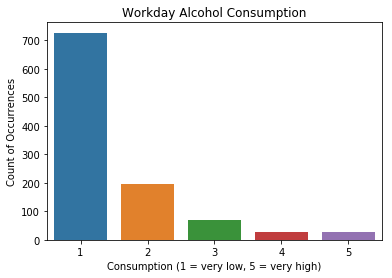

In [426]:
fig, ax = plt.subplots()
fig = sns.countplot(x="Dalc", data=combined_data)
ax.set_title('Workday Alcohol Consumption')
ax.set_xlabel('Consumption (1 = very low, 5 = very high)')
ax.set_ylabel('Count of Occurrences')

Text(0,0.5,'Count of Occurrences')

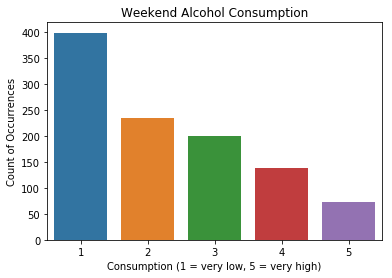

In [427]:
fig, ax = plt.subplots()
fig = sns.countplot(x="Walc", data=combined_data)
ax.set_title('Weekend Alcohol Consumption')
ax.set_xlabel('Consumption (1 = very low, 5 = very high)')
ax.set_ylabel('Count of Occurrences')

Text(0,0.5,'Count of Occurrences')

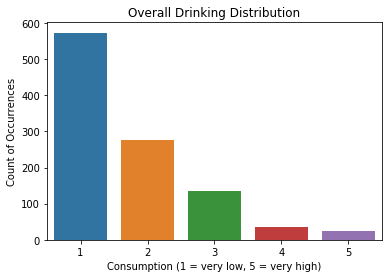

In [428]:
fig, ax = plt.subplots()
fig = sns.countplot(x="overall_drinking", data=combined_data)
ax.set_title('Overall Drinking Distribution')
ax.set_xlabel('Consumption (1 = very low, 5 = very high)')
ax.set_ylabel('Count of Occurrences')

As expected, drinking levels are very low on workdays and pick up on the weekends. Overall drinking follows a relatively similar distribution to workday alcohol consumption which means that for most people, drinking does not change a huge amount from workday to weekend.

### Age Distribution

Text(0,0.5,'Count of Occurrences')

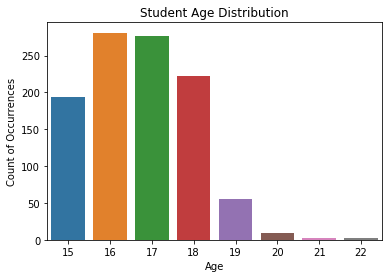

In [429]:
fig, ax = plt.subplots()
fig = sns.countplot(x="age", data=combined_data)
ax.set_title('Student Age Distribution')
ax.set_xlabel('Age')
ax.set_ylabel('Count of Occurrences')

Both schools are secondary schools (the equivalent of American high schools) so it makes sense that most students are between 15 and 18. There are a few notable outliers here, with students as old as 21-22.

### Correlations
Since we want to predict drinking level from the features in the data set, it is only natural to look at the correlations between the features. 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text xticklabel objects>)

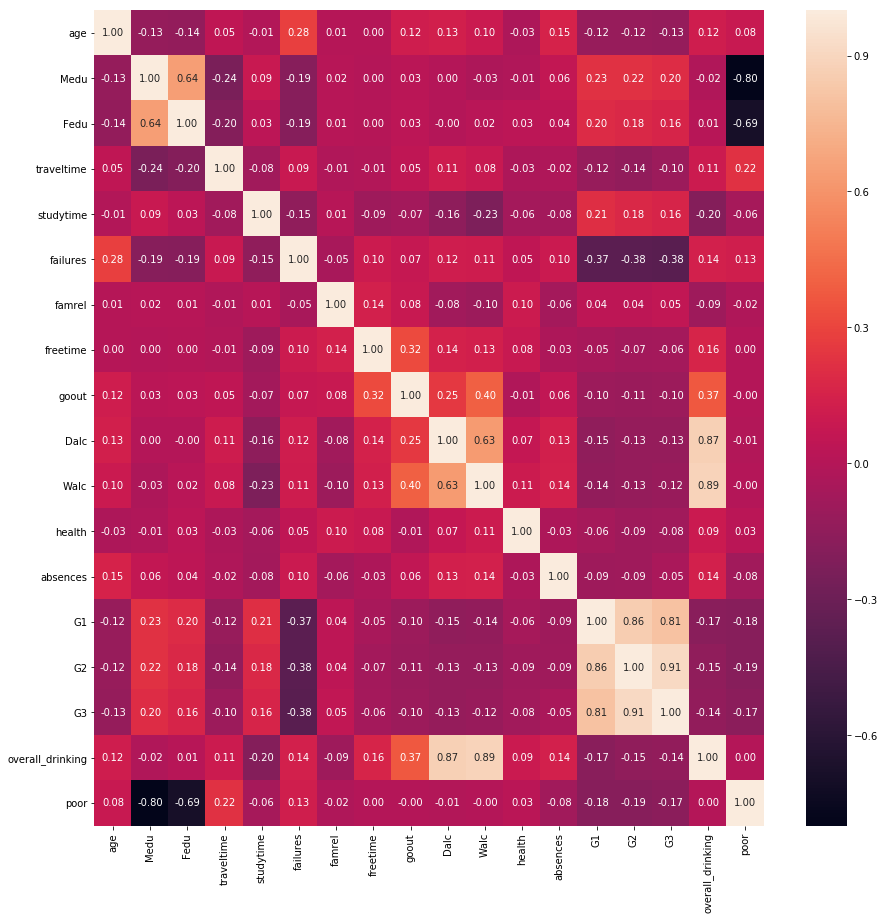

In [430]:
plt.figure(figsize=(15,15))
sns.heatmap(combined_data.corr(),annot = True,fmt = ".2f")
plt.xticks(rotation=90)

Looking at our variable of interest (overall_drinking), there are some variables that stick out (ignoring Walc and Dalc since overall_drinking is derived from those): 

- Age: As of July 1, 2015, the [drinking age in Portugal was 18](https://www.publico.pt/2015/06/30/sociedade/noticia/1-de-julho-nova-legislacao-sobre-o-alcool-e-a-vacina-prevenar-em-vigor-1700632). However, this data set was collected in 2008 and the drinking age at the time was 16. As such, it makes sense that drinking and age are correlated.
- Travel Time: This feature describes how long a student takes to travel to school. A longer travel time could indicate that the student comes from a rural area as opposed to the urban area where the schools are located, and living in a rural area could be correlated with higher drinking but that needs more investigation.
- Study Time: Study time has a relatively strong negative correlation with overall drinking, which makes sense as more time studying means less time to drink. More study time also indicates a more engaged student which could be seems to be negatively correlated with drinking when taking this and the negative correlation with grades into account.
- Failures: Failures is positively correlated with overall drinking. This is good for our purposes as assistance with drinking could also help reduce failure rate, ensuring better physical and mental health for students.
- Free Time: Free time has a positive relationship with drinking which makes sense since more free time means more opportunity to drink.
- Go Out: Going out with friends is very strongly correlated with drinking relative to our other variables, which makes a lot of sense since drinking tends to be a social activity.
- Absences: Absences are correlated with drinking. This is another variable that works for our purposes since absent students need support anyway, there can just be support for healthy drinking added.
- G1, G2, G3: These refer to first period grade, second period grade, and final grade. These are all negatively correlated with drinking which supports the notion that good students do not tend to be heavy drinkers.

Surprises:

- Our created variable, low_income, is not correlated with overall drinking at all!
- The correlation between grades and drinking seems to drop as the year goes on.

As a note, correlations are not calculated for our categorical variables since there is no real _increase_  or _order_ in a categorical variable. As such, we will need to use a chi squared test to assess the relationship between these and overall_drinking in our statistical methods section.

### Categorical Variable Distributions
Since categorical variables are not included in .describe() and we did not find any missing data in the data set, we wanted to check the distribution of categorical variables to see if there were any features we need to be careful about:

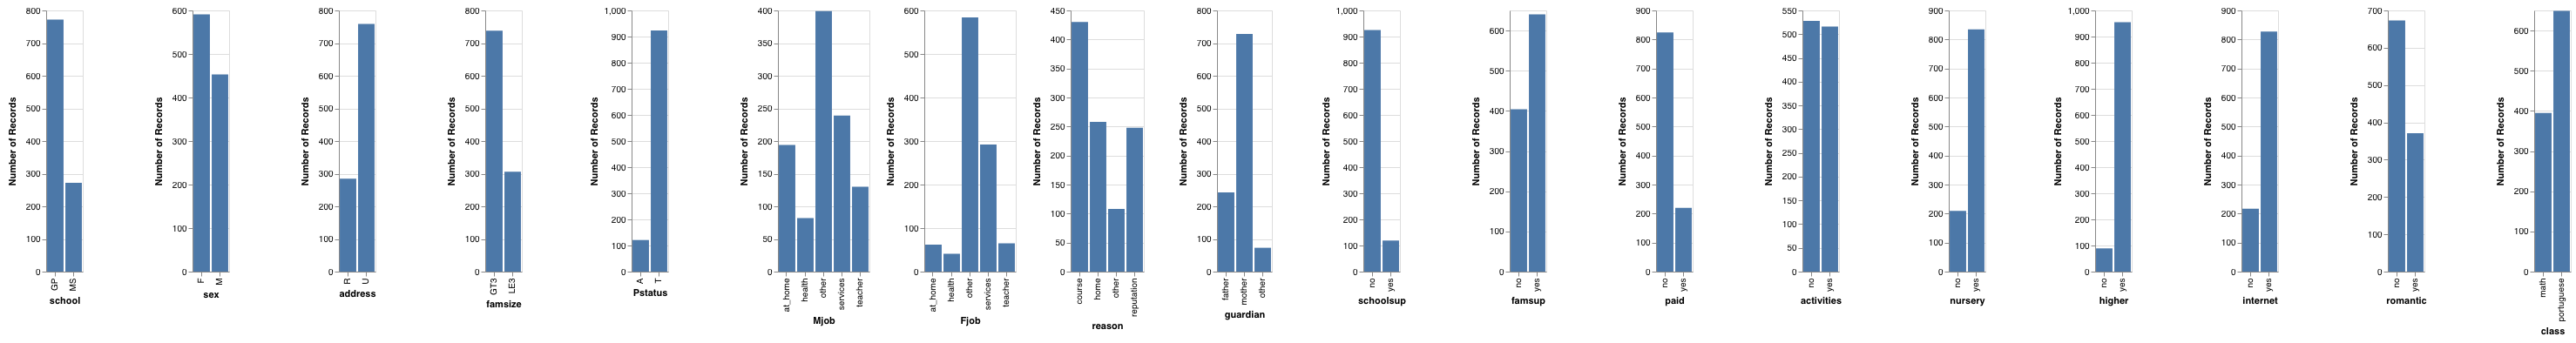

In [431]:
alt.Chart(combined_data).mark_bar().encode(
    alt.X(alt.repeat("column"), type='ordinal'),
    alt.Y('count()')
).repeat(
    column=list(combined_data.loc[:, combined_data.dtypes == object])
)

Looking at these distributions, there are four features that include an 'other' option: Mjob, Fjob, reason, and guardian. Reason and guardian are not too concerning since the amount of 'other' responses are quite low. However, in both the Mjob and Fjob categories, the 'other' option is the most common by a large margin. This is slightly concerning as it means we are basically missing the data for this feature when it comes to predicting drinking. However, we do have many other variables to use to try and predict overall_drinking.

### Summary Statistics

Here are the summary statistics for the data: 

In [432]:
combined_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,overall_drinking,poor
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954,1.717433,0.409004
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796,0.971128,0.491886
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000,1.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000,1.000000,0.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000,2.000000,1.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000,5.000000,1.000000


A few observations of note here:

- The average age is around 16 and a half.
- The **vast** majority of people have no past class failures. Failures goes up to 4 and anything past that is not tracked but this does not matter in this case since the max is 3.
- Overall drinking is quite low with 75% of people drinking at a level of 'low' or 'very low'.

## Statistical Methods
Our independent variable, overall drinking, is categorical. As a result, we need to use a chi-squared test to assess the statistical relationship between variables. We will test age, travel time, study time, failures, free time, go out, absences, and G1-3 since those were correlated with overall drinking. Furthermore, we need to test all of our categorical variables for inclusion in our end model.


### Chi Squared Tests

In order to use chi-squared, we need to convert our categories into integer data.

In [433]:
categorical_indices = combined_data.loc[:, combined_data.dtypes == object].columns.values

In [434]:
for index in categorical_indices:
    combined_data[index] = combined_data[index].replace(combined_data[index].unique(), np.arange(len(combined_data[index].unique())))

for index in categorical_indices:
    c, p, dof, expected = chi2_contingency(combined_data[[index, 'overall_drinking']])
    print(index + ': ' + str(p))
    
continuous_indices = ['age', 'traveltime', 'studytime', 'failures', 'freetime', 'goout', 'absences', 'G1', 'G2', 'G3']
for index in continuous_indices:
    c, p, dof, expected = chi2_contingency(combined_data[[index, 'overall_drinking']])
    print(index + ': ' + str(p))

school: 1.0
sex: 1.0
address: 1.0
famsize: 1.0
Pstatus: 1.0
Mjob: 0.9999999999999973
Fjob: 1.0
reason: 0.9383807399485525
guardian: 0.9999999999999365
schoolsup: 1.0
famsup: 1.0
paid: 1.0
activities: 1.0
nursery: 1.0
higher: 1.0
internet: 1.0
romantic: 1.0
class: 1.0
age: 1.0
traveltime: 1.0
studytime: 1.0
failures: 0.9999979887804884
freetime: 1.0
goout: 1.0
absences: 1.9544129259101132e-84
G1: 1.0
G2: 0.9999947201866805
G3: 0.00016207236339146409


Out of all our variables, it looks like only absences and G3 have a significant difference with overall drinking. We will have to use feature selection to tell whether these truly are the best variables to predict overall drinking in our model.

### Feature Selection

In [435]:
# Renaming to data to save time
data = combined_data

As we are trying to predict overall drinking for the students, we need to take out daily alcohol and weekly alcohol consumption from our train/test split as well as from feature selection and model training. This is because these values are already represented in the overall_drinking feature. We also have to rename the 'class' column to 'cls', as it was causing errors.  

In [436]:
data['cls'] = data['class']
data = data.drop(['class'], axis=1)
data = data.drop(['Dalc'], axis=1)
data = data.drop(['Walc'], axis=1)

We are going to narrow down our data to outcome (overall_drinking) and the two variables that were found to have a statistically significant difference from the outcome, G3 and absences.

In [437]:
outcome = data['overall_drinking']
data = data[['G3', 'absences']]

Now we split the data into training and test datasets with a standard 70/30 split because we don't want to overfit the model.

In [438]:
train_features, test_features, train_outcome, test_outcome = train_test_split(
    data,
    outcome,
    test_size=0.30
)

### Pipeline Modeling - KNN Classifier

First, we create a pipeline with source code from lecture, then define a grid to search through, and then we inlucde the degree of polynomial. 

In [439]:
pipe = make_pipeline(Imputer(), MinMaxScaler(), KNeighborsClassifier())

param_grid = {'kneighborsclassifier__n_neighbors':range(1, 20), 'kneighborsclassifier__weights': ['uniform', 'distance']}

grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error") # you may want to specify more parameters!

In [440]:
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-0.7197452229299363

This value means that on average, we are about .7 away from the real category. 

In [441]:
grid.cv_results_['params'][grid.best_index_]

{'kneighborsclassifier__n_neighbors': 13,
 'kneighborsclassifier__weights': 'uniform'}

In [442]:
knn_test_predict = grid.predict(test_features)

In [443]:
accuracy_score(knn_test_predict, test_outcome, normalize=True)

0.5222929936305732

Our accuracy score is around 0.5. This means that we exactly predict the overall drinking around 50% of the time. 

### Pipeline Modeling - XGB Classifier

We also created a pipeline based on an XGB Classifier to see if we could improve our accuracy score. 

In [444]:
pipe2 = make_pipeline(Imputer(), MinMaxScaler(), XGBClassifier())

In [445]:
param_grid2 = {'xgbclassifier__nthread': range(1,5), 'xgbclassifier__max_depth': range(5,9), 'xgbclassifier__learning_rate': [.005, .01, .02]}
grid2 = GridSearchCV(pipe2, param_grid2, scoring="neg_mean_absolute_error") 

To get more accurate results, we decided to tune our model. nthread theoretically makes the model run faster by using more cores if available, max_depth is used to control over-fitting, and learning_rate which shrinks the weights on each step of the model.  

In [446]:
grid2.fit(train_features, train_outcome)
xgb_test_predict = grid2.predict(test_features)
grid2.score(test_features, test_outcome)

-0.7292993630573248

In [447]:
accuracy_score(xgb_test_predict, test_outcome, normalize=True)

0.5127388535031847

The XGBClassifier is reporting a score of around 0.5 on average. This score is normalized to 1. This means that we are exactly predicting overall drinking about 50% of the time. 

### Graph of Differences between KNN and XGB Predictions

In [448]:
test_features['xgb_predict'] = xgb_test_predict
test_features['knn_predict'] = knn_test_predict
test_features['real_outcome'] = test_outcome

Here is the chart of KNN predictions, XGB predictions, real outcomes, absences, and G3. 

In [449]:
test_features.describe()

,G3,absences,xgb_predict,knn_predict,real_outcome
count,314.000000,314.000000,314.000000,314.000000,314.000000
mean,11.350318,4.863057,1.235669,1.168790,1.691083
std,3.874000,7.626486,0.577978,0.415568,0.970878
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,10.000000,0.000000,1.000000,1.000000,1.000000
50%,12.000000,2.000000,1.000000,1.000000,1.000000
75%,14.000000,6.000000,1.000000,1.000000,2.000000
max,19.000000,75.000000,4.000000,3.000000,5.000000


Here we graph the real outcomes and the predicted values from the XGB predictions. From this graph, you can see that our predictions were alright; they are pretty evenly distributed on either side of the graph, but there is a lot of over and under prediction. 

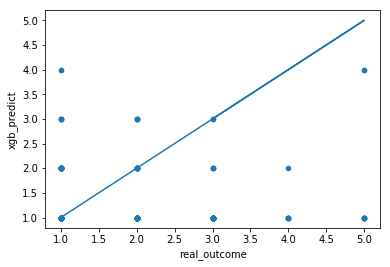

In [450]:
test_features.plot('real_outcome', 'xgb_predict', kind='scatter')
plt.plot(test_features.real_outcome, test_features.real_outcome)
plt.show()

Here we graph the real outcomes and the predicted values from the KNN predictions. From this graph, you can see that our predictions were slightly better than the XGB predictions. The points are again pretty distributed on either side of the graph, but there is slightly less over and under prediction than seen in the XGB predictions (the KNN predictions are closer to the actual line). 

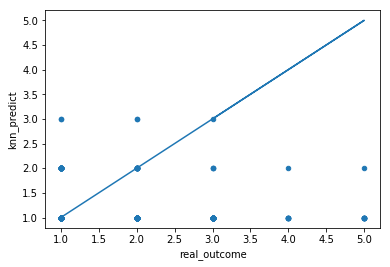

In [451]:
test_features.plot('real_outcome', 'knn_predict', kind='scatter')
plt.plot(test_features.real_outcome, test_features.real_outcome)
plt.show()

In [461]:
test_features['knn_error'] = test_features['real_outcome'] - test_features['knn_predict']
test_features['xgb_error'] = test_features['real_outcome'] - test_features['xgb_predict']

Finally, we are plotting the errors by each variable (G3 and absences) for each model.

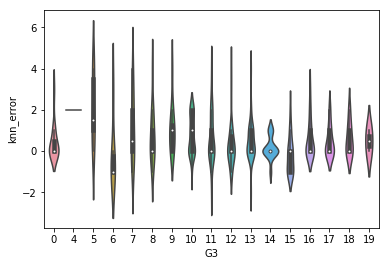

In [463]:
sns.violinplot(test_features['G3'], test_features['knn_error'])

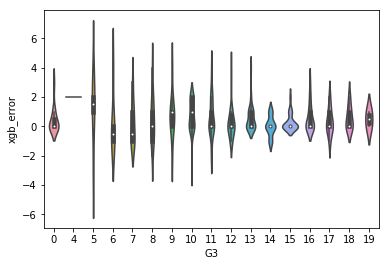

In [457]:
sns.violinplot(test_features['G3'], test_features['xgb_error'])

For G3, the variation in the errors seems to be smaller for larger values of G3, which means the models are both better at predicting overall drinking when the values of G3 are higher. 

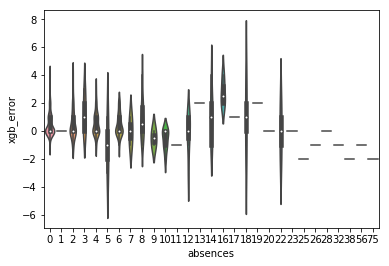

In [458]:
sns.violinplot(test_features['absences'], test_features['xgb_error'])

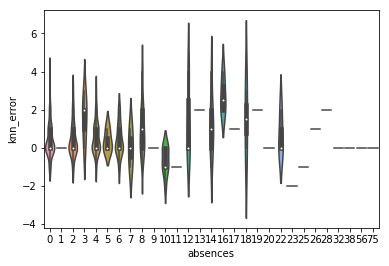

In [460]:
sns.violinplot(test_features['absences'], test_features['knn_error'])

For absences, there does not seem to be any serious patterns in the errors. 